### 영상처리의 기본 연산
- 영상처리 : 화소 입장에서 봤을 때 새로운 값을 부여받는 것
- 새로운 값을 '어디에서' 취하느냐에 따라 연산이 구분된다
  - 점 연산(point operation) : 어떤 화소가 자신의 값만 보고 새로운 값을 결정하는 경우
  - 영역 연산(area operation) : 이웃에 있는 몇 개의 화소들을 보고 새로운 값을 정하는 경우
  - 기하 연산(geometric operation) : 일정한 기하학적 규칙에 따라 다른 곳에 있는 값을 취하는 경우

### 점 연산
점 연산의 일반적인 식은 다음과 같다.
$$
f_{out}(j,i) = t(f_{1}(j,i),f_{2}(j,i),...,f_{k}(j,i))
$$
출력 영상 f_out에서 화소 (j,i)의 값은 k개의 입력 영상에서 같은 위치에 존재하는 화소의 값에 따라 정해진다.  
대부분 k=1인 한 장의 영상을 입력한다.

$$
f_{out}(j,i) = t(f(j,i)) = \begin{cases} min(f(j,i)+a,L-1), (Lighter) \\ max(f(j,i)-a,0), (Darker) \\ (L-1) - f(j,i), (Reversal)  \end{cases}
$$

위의 두 식은 양수 a를 더해서 밝게 만들거나 어둡게 만드는 연산이다.  
세 번째 식은 어두운 곳은 밝게 밝은 곳은 어둡게 반전시킨다.  
그리고 이들 모두 선형 연산(linear operation)에 속한다. 

$$
f_{out}(j,i) = (L-1) \times \hat{f}(j,i)^{\gamma} \\
Then, \hat{f}(j,i) = \frac{f(j,i)}{L-1}
$$

위 식은 감마 수정(gamma correction)이라 부르는 비선형 연산(nonlinear operation)으로, hat(f)은 [0,1] 사이 값을 갖는 정규 영상이다.
감마 값이 1보다 작으면 밝아지고 1보다 크면 어두워진다.
비선형 연산은 주로 모니터나 프린터의 색상을 조절할 때 사용된다.

점 연산에 속하는 또다른 것으로 히스토그램 평활화를 들 수 있다. 이때는 누적 히스토그램이 변환 함수 역할을 한다.

응용에 따라 맨처음 식에서 영상의 개수 k가 2이상인 경우가 있다.
예를들어, 컬러 영상을 명암 영상으로 변환하는 경우 R, G, B 세 채널이 입력이므로 k=3인 셈이다.

또 다른 경우로 장면 디졸브 (scene dissolve)라는 효과가 있다.
식은 다음과 같이 표현 된다.

$$
f_{out}(j,i) = \alpha f_{1}(j,i) + (1-\alpha)f_{2}(j,i)
$$

장면 디졸브는 앞의 영상 f1이 서서히 뒤에 있는 영상 f2로 전환된다.

### 코드구현

먼저 선형 연산 부터 실행하면 다음과 같다.
좌측 상단이 원본, 우측 상단이 밝게하는 연산
좌측 하단이 어둡게하는 연산, 우측 하단이 반전 연산이다.

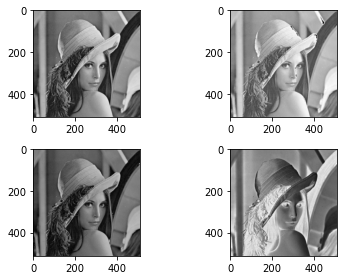

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/lena.jpg',cv2.IMREAD_GRAYSCALE)
a = 32

fig = plt.figure()
plt.subplot(221)
plt.imshow(img,cmap='gray')
plt.subplot(222)
plt.imshow(np.clip(img+a,0,255),cmap='gray')
plt.subplot(223)
plt.imshow(np.clip(img-a,0,255),cmap='gray')
plt.subplot(224)
plt.imshow(255-img,cmap='gray')
fig.tight_layout()
plt.show()

다음은 감마연산(비선형 연산)을 한다.
이를 위해서 함수를 작성할 것이다.
우선 영상을 0~255를 갖는 값을 정규화 해야한다.
그리고 이 이미지의 감마제곱에 다시 255를 곱한다.

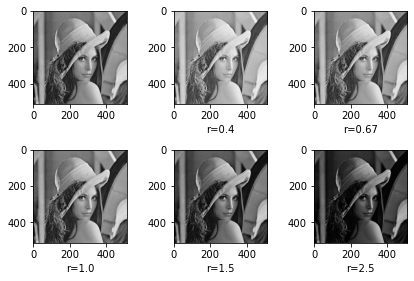

In [2]:
def gamma_operation(img,gamma,L):
    hat_img = img.copy() / float(L)
    return np.clip(L*((hat_img)**gamma),0,L)

fig = plt.figure()
plt.subplot(231)
plt.imshow(img,cmap='gray')
plt.subplot(232)
plt.imshow(gamma_operation(img,0.4,255),cmap='gray')
plt.xlabel('r=0.4')
plt.subplot(233)
plt.imshow(gamma_operation(img,0.67,255),cmap='gray')
plt.xlabel('r=0.67')
plt.subplot(234)
plt.imshow(gamma_operation(img,1.0,255),cmap='gray')
plt.xlabel('r=1.0')
plt.subplot(235)
plt.imshow(gamma_operation(img,1.5,255),cmap='gray')
plt.xlabel('r=1.5')
plt.subplot(236)
plt.imshow(gamma_operation(img,2.5,255),cmap='gray')
plt.xlabel('r=2.5')
fig.tight_layout()
plt.show()


감마 값이 클 수록 이미지가 어두워지고 감마값이 작을 수록 이미지가 밝은 것을 확인 할 수 있다.

이번에는 디졸브 효과를 구현한다.
먼저 색상영상 두개를 불러온다.

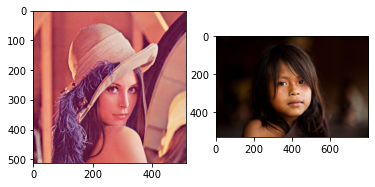

In [3]:
lena = cv2.cvtColor(cv2.imread('./data/lena.jpg'),cv2.COLOR_BGR2RGB)
girl = cv2.cvtColor(cv2.imread('./data/girl.jpg'),cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.imshow(lena)
plt.subplot(122)
plt.imshow(girl)
plt.show()

디졸브 효과를 주려면 이미지 두개의 사이즈가 일관되어야 하므로 cv2.resize()를 이용해 크기를 조정해준다.

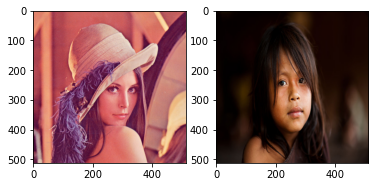

In [4]:
girl=cv2.resize(girl,lena.shape[:2])
plt.subplot(121)
plt.imshow(lena)
plt.subplot(122)
plt.imshow(girl)
plt.show()

이제 알파값을 1에서 시작해 0까지 내려가며 두 이미지의 가중치를 조절하면 다음과 같이 디졸브 효과가 수행된다.
횟수는 임의로 설정했다.

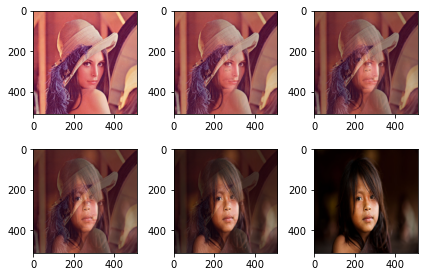

In [5]:
alpha = 1
leng = 5
step = alpha/leng
fig = plt.figure()
for i in range(6):
    n_img = np.uint8(lena*alpha + girl*(1-alpha))

    plt.subplot(231+i)
    plt.imshow(n_img)
    alpha-=step
fig.tight_layout()
plt.show()

### 영역 연산
다음의 그림은 두 가지 연산인 상관(Correlation)과 컨볼루션(Convolution)에 대한 그림이다.
![](./data/correlation_convolution.jpg)
윈도우 u는 검출하려는 물체이고, f는 입력 영상영상이라 할때 풀어야 하는 문제는 f의 어디에 u가 있는지 찾는 것이다.

#### 상관과 컨볼루션
위의 사진에서 영상 g의 값은 6번째 index에서 최대값을 가진다. 이유는 이 위지에 찾고자 하는 u가 있기 때문이다. 반면, u와 많이 다른 곳일수록 낮은 값임을 알 수 있다. 이와 같이, 물체를 표현하는 윈도우 u와 입력 영상 f가 얼마나 비슷한지 측정해 주는 연산을 상관(correlation)이라 부른다. 대표적인 영역 연산이며 물체의 크기나 회전 변환이 없다고 가정한다. 하지만 현실에서는 물체가 크기, 회전, 밝기에서 큰 변화를 나타내기 때문에 제한이 있다.  
컨볼루션(convolution)은 상관과 비슷한데, 단지 윈도우를 적용하기 전에 뒤집는 것만 다르다.  

연산 도중에 값이 최신화 되면 안되기 때문에 별도의 영상 g에 연산값을 기록해야 한다.
상관과 컨볼루션의 연산을 식으로 표현하면 다음과 같다.  
$$
1차원 \begin{cases}상관 g(i) = u \otimes f = \underset{{x=-(w-1)/2}}{\overset{(w-1)/2}{\sum}}u(x)f(i+x) \\
컨볼루션 g(i) = u  \circledast f = \underset{{x=-(w-1)/2}}{\overset{(w-1)/2}{\sum}}u(x)f(i-x)
\end{cases} \\
2차원 \begin{cases}상관 g(j,i) = u \otimes f = \underset{{y=-(h-1)/2}}{\overset{(h-1)/2}{\sum}} \underset{{x=-(w-1)/2}}{\overset{(w-1)/w}{\sum}}u(y,x)f(j+y,i+x) \\
컨볼루션 g(j,i) = u  \circledast f = \underset{{y=-(h-1)/2}}{\overset{(h-1)/2}{\sum}} \underset{{x=-(w-1)/2}}{\overset{(w-1)/w}{\sum}}u(y,x)f(j-y,i-x)
\end{cases}
$$
많은 문헌과 연구자들이 상관 대신 컨볼루션이라는 용어를 주로 사용하기 때문에 상관이 컨볼루션으로 불린다. 이 점을 주의하자.  
윈도우는 마스크(mask), 커널(kernel), 템플릿(template), 필터(filter)라고도 부른다. 

컨볼루션은 일반적인(generic) 연산이다. 컨볼루션 그 자체가 특정 목적이 아니라 마스크의 모양과 크기가 정해지면 그때 비로소 특정 목적이 결정된다. 아래는 널리 사용되는 여러 마스크들의 형태이다.
![](./data/operation_masks.jpg)
박스 마스크 : 정규 마스크(normalized mask) 라고도 부른다. 마스크의 화소값을 모두 합하면 1이 되도록 정규화를 하기 때문이다. 결과 영상의 화소값이 원래 영상과 비슷한 범위를 가진다.  
가우시안 마스크 : 표준편차가 0.5일 때이다. 박스와 달리 화소로부터 거리에 따라 가중치를 부여한다.  
박스나 가우시안과 같은 연산을 스무딩(smoothing) 연산이라 부르며 주로 영상 향상(enhancemant) 작업에 많이 사용한다. 영상의 노이즈는 주로 어떤 화소가 이웃한 화소에 비해 크거나 작은 경우 인데, 스무딩 연산은 이웃 화소끼리의 차이를 줄여 보다 평탄한 영상으로 만들어 주기 때문이다.  
샤프닝 : 에지를 뭉개는 스무딩과 반대로 에지를 강조하는 효과를 준다.  
에지 마스크 : 일종의 미분 연산자로 영상의 값의 변화를 측정한다. 수평 에지마스크는 y-방향의 미분값, 수직 에지 마스크는 x-방향의 미분값을 측정한다.  
모션 : 모션효과를 생성한다.

각 필터는 다음과 같이 설정했다.

In [6]:
# 박스
box_filter = np.ones((3,3))/9
# 가우시안
gaussian_filter = np.array([[0.,0.,0.0002,0.,0.],
                            [0.,0.0113,0.0837,0.0113,0.],
                            [0.0002,0.0837,0.6187,0.0837,0.0002],
                            [0.,0.0113,0.0837,0.0113,0.],
                            [0.,0.,0.0002,0.,0.]])
# 샤프닝
sharpening_filter = np.array([[0,-1,0],
                             [-1,5,-1],
                             [0,-1,0]])
# 수평 에지
horizontal_filter = np.array([[1,1,1],
                              [0,0,0],
                              [-1,-1,-1]])
# 수직 에지
vertical_filter = np.array([[1,0,-1],
                              [1,0,-1],
                              [1,0,-1]])
# 모션
motion_filter = np.array([[0.0304,0.0501,0.,0.,0.],
                            [0.0501,0.1771,0.0519,0.,0.],
                            [0.,0.0519,0.1771,0.0519,0.],
                            [0.,0.,0.0519,0.1771,0.0501],
                            [0.,0.,0.,0.0501,0.0304]])

각 인덱스마다 행렬 연산을 하면 속도가 꽤 느리다. 이러한 경우 보통 im2col을 사용한다.
코드는 '밑바닥부터 시작하는 딥러닝'에서 참고했다.[코드 출처](https://github.com/WegraLee/deep-learning-from-scratch/blob/6c2eabeaa404aa16f24a32d582b2476653517a76/common/util.py#L39)

In [7]:
def im2col(input_data, filter_h, filter_w):
    H, W, C = input_data.shape

    u_pad_h = (filter_h-1)//2
    d_pad_h = (filter_h-1)//2
    l_pad_w = (filter_w-1)//2
    r_pad_w = (filter_w-1)//2
    if (filter_h-1) %2 ==1:
        u_pad_h +=1
    if (filter_w-1)%2 ==1:
        l_pad_w +=1
    input_data = cv2.copyMakeBorder(input_data, u_pad_h, d_pad_h, l_pad_w, r_pad_w, cv2.BORDER_REPLICATE)

    img = np.transpose(input_data,(2,0,1))
    col = np.zeros(( C, filter_h, filter_w, H, W))

    for y in range(filter_h):
        y_max = y + H
        for x in range(filter_w):
            x_max = x + W
            col[:, y, x, :, :] = img[:, y:y_max:1, x:x_max:1]

    col = np.transpose(col,(0,3,4,1,2)).reshape(C*H*W, -1)

    return col


def conv(img,filter):
    filter_h ,filter_w = filter.shape
    img_h,img_w,c = img.shape
    col = im2col(img,filter_h,filter_w)
    col_filetr = filter.reshape((1,-1)).T
    out = np.dot(col, col_filetr)
    return np.clip(np.transpose(out.reshape((c, img_h, img_w)),(1, 2,0)),0,255)


아래 사진은 각 필터를 적용한 그림이다.

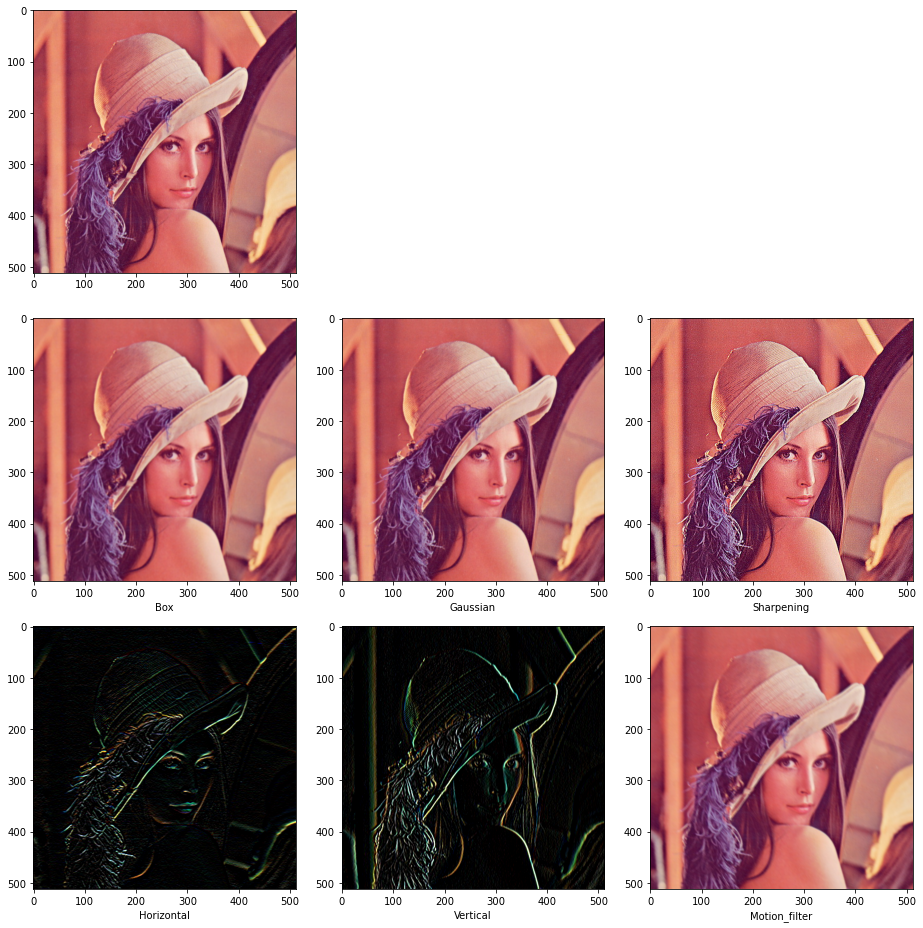

In [8]:
fig = plt.figure(figsize=(13,13))
plt.subplot(331)
plt.imshow(lena)

plt.subplot(334)
box = np.uint8(conv(lena,box_filter))
plt.xlabel("Box")
plt.imshow(box)

plt.subplot(335)
gau = np.uint8(conv(lena,gaussian_filter))
plt.xlabel("Gaussian")
plt.imshow(gau)

plt.subplot(336)
sharp = np.uint8(conv(lena,sharpening_filter))
plt.xlabel("Sharpening")
plt.imshow(sharp)

plt.subplot(337)
hori = np.uint8(conv(lena,horizontal_filter))
plt.xlabel("Horizontal")
plt.imshow(hori)

plt.subplot(338)
veti = np.uint8(conv(lena,vertical_filter))
plt.xlabel("Vertical")
plt.imshow(veti)

plt.subplot(339)
motion = np.uint8(conv(lena,motion_filter))
plt.xlabel("Motion_filter")
plt.imshow(motion)

fig.tight_layout()
plt.show()

opencv에서는 cv2.filter2D 함수를 사용하면 간편하다. 최적화가 이미 잘되어 있기 때문에 속도면에서도 훨씬 빠르다.

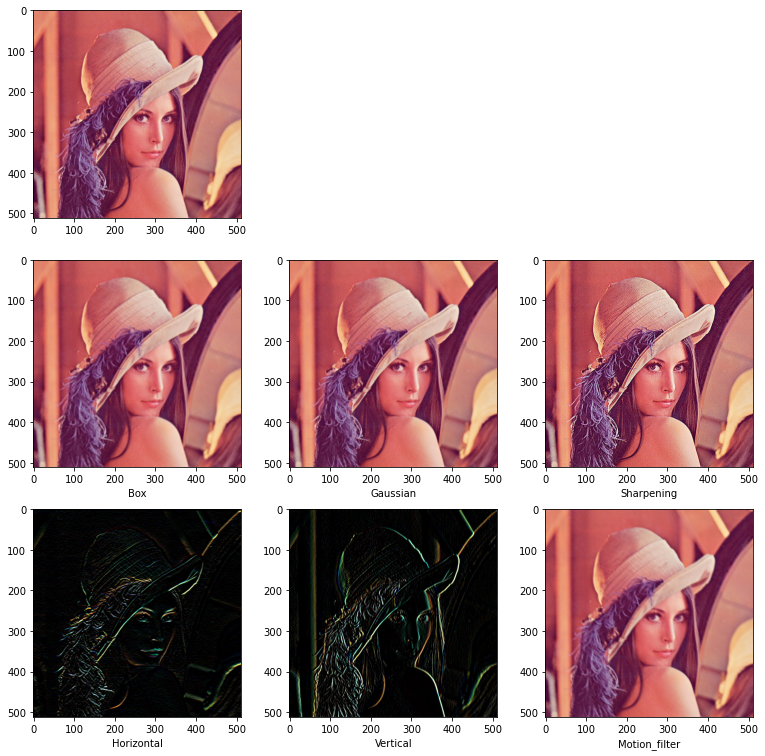

In [9]:
fig = plt.figure(figsize=(13,13))
plt.subplot(331)
plt.imshow(lena)

plt.subplot(334)
cv_box = cv2.filter2D(lena,-1,box_filter)
plt.xlabel("Box")
plt.imshow(cv_box)

plt.subplot(335)
cv_gau = cv2.filter2D(lena,-1,gaussian_filter)
plt.xlabel("Gaussian")
plt.imshow(cv_gau)

plt.subplot(336)
cv_sharp = cv2.filter2D(lena,-1,sharpening_filter)
plt.xlabel("Sharpening")
plt.imshow(cv_sharp)

plt.subplot(337)
cv_hori = cv2.filter2D(lena,-1,horizontal_filter)
plt.xlabel("Horizontal")
plt.imshow(cv_hori)

plt.subplot(338)
cv_veti = cv2.filter2D(lena,-1,vertical_filter)
plt.xlabel("Vertical")
plt.imshow(cv_veti)

plt.subplot(339)
cv_motion = cv2.filter2D(lena,-1,motion_filter)
plt.xlabel("Motion_filter")
plt.imshow(cv_motion)
plt.show()

위의 사진을 보면 motion_filter의 커널이 너무 작아 감이 잘 오지 않는다. opencv함수는 최적화가 잘 되어 있으므로 크기가 큰 커널을 사용해도 느리지 않다. 이를 이용해 motion filter를 생성하는 코드를 작성하자 코드는 [Stackoverflow](https://stackoverflow.com/questions/40305933/how-to-add-motion-blur-to-numpy-array)에서 참고했다.

In [10]:
def apply_motion_blur(size, angle):
    k = np.zeros((size, size), dtype=np.float32)
    k[ (size-1)// 2 , :] = np.ones(size, dtype=np.float32)
    k = cv2.warpAffine(k, cv2.getRotationMatrix2D( (size / 2 -0.5 , size / 2 -0.5 ) , angle, 1.0), (size, size) )
    k = k * ( 1.0 / np.sum(k) )
    return k

커널의 사이즈는 51정도로 하고 45도 방향으로 모션을 주면 결과는 다음과 같다.

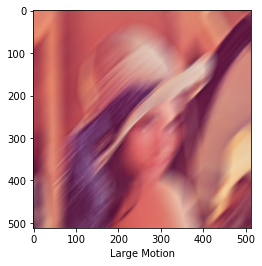

In [11]:
size = 51
large_motion_filter=apply_motion_blur(size,45)

cv_large_motion = cv2.filter2D(lena,-1,large_motion_filter)
plt.xlabel("Large Motion")
plt.imshow(cv_large_motion)
plt.show()

상수를 변수에 곱하고 그것들을 단순히 합하기 때문에 위의 convolution 필터들은 선형이다. 

이와 반대로 비선형 연산을 하는 필터들이 있다. 그 중 대표적인 필터가 메디안(median)필터이다. 메디안은 여러 개의 값을 정렬했을 때 가운데 위치한 값을 취한다.
이 필터는 솔트페퍼 잡음(salt-and-pepper noise)제거에 매우 효과적이다.

솔트페퍼 잡음 이미지는 다음과 같이 간단하게 10%의 픽셀을 무작위로 선정해 255값으로 변경했다.

In [12]:
salt_idx = np.random.random(lena.shape[:2])
salt_img = lena.copy()
salt_img[salt_idx>0.9] =255

메디안 필터는 다음과 같이 영역내에서 중간값을 선정했다.

In [13]:
def median(img,filter_size):
    img_h,img_w,c = img.shape
    pad= (filter_size-1)//2
    out_img = np.zeros((img_h,img_w,c))
    img = cv2.copyMakeBorder(img, pad, pad, pad, pad,  cv2.BORDER_REPLICATE)
    img = np.transpose(img,(2,0,1))

    for y in range(img_h):
        for x in range(img_w):
            partial = img[:,y:y+filter_size,x:x+filter_size].reshape(c,-1)
            partial.sort()
            out_img[y,x]= partial[:,(filter_size**2)//2]

    return np.uint8(out_img)

솔트페퍼 잡음이 추가된 이미지에 가우시안 필터를 적용한 결과와 메디안 필터를 적용한 결과는 다음과 같다.

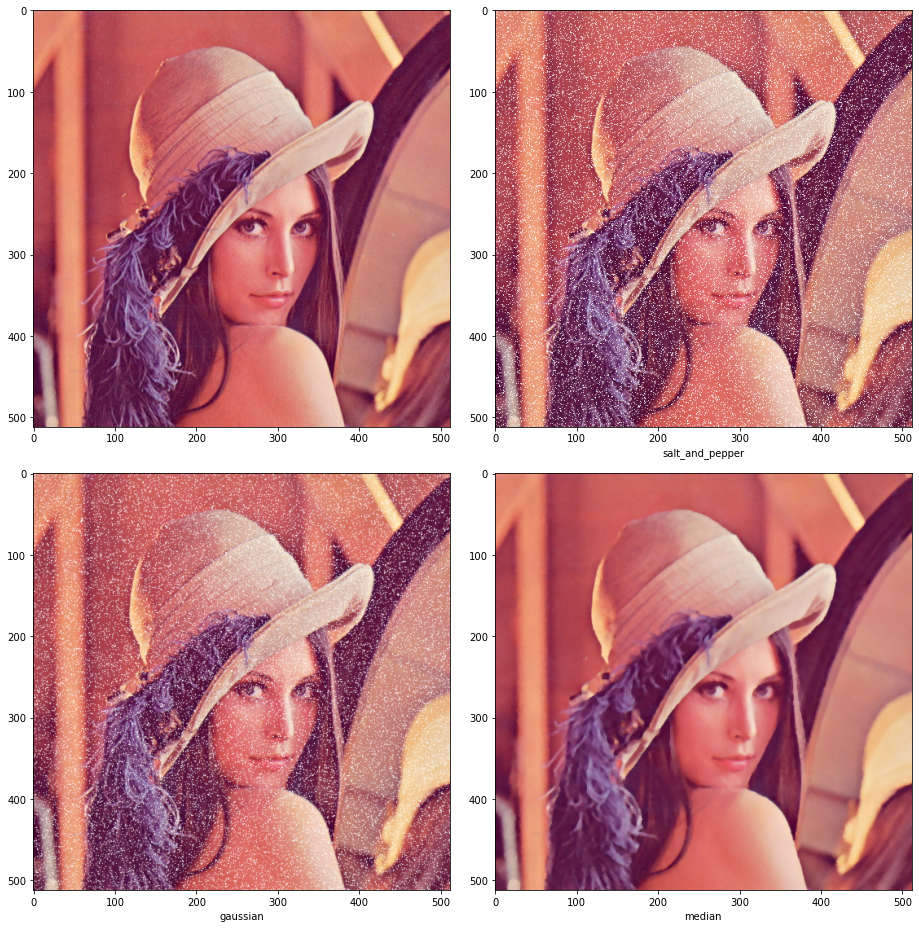

In [14]:
fig = plt.figure(figsize=(13,13))
plt.subplot(221)
plt.imshow(lena)

plt.subplot(222)
plt.imshow(salt_img)
plt.xlabel("salt_and_pepper")

plt.subplot(223)
salt_gaussian = np.uint8(conv(salt_img,gaussian_filter))
plt.imshow(salt_gaussian)
plt.xlabel("gaussian")

plt.subplot(224)
salt_median = median(salt_img,5)
plt.imshow(salt_median)
plt.xlabel("median")

fig.tight_layout()
plt.show()

메디안의 경우 잡음을 많이 제거한 것을 볼 수 있다.
가우시안은 잡음이 덜 제거되었는데, 더 제거하고 싶으면 필터의 크기를 키우면 되지만 이미지의 경계가 뭉개지는 현상이 심해진다.
이러한 특성 때문에 메디안을 에지보존(Edge preseving) 스무딩 필터라 부르기도 한다.

또 다른 유명한 에지보존 스무딩 필터 중 양방향 필터(Bilateral filter)가 있다.
양방향 필터는 두 점 사이의 거리에 대한 가우시안과 두 점의 픽셀 값 차이에 의한 가우시안 값을 고려하는 방식이다.
두 점 사이의 거리에 대한 가우시안은 가우시안 필터와 동일하다.
다른 가우시안 값은 두 점의 픽셀 값 차이가 심한 에지 영역에서 0에 가깝기 때문에 에지 근방에서는 에지가 보존된다.
식은 다음과 같다.
$$
g_{p} = \frac{1}{W_p} \sum_{q \in S}G_{\sigma_{s}}(\begin{Vmatrix}p-q \end{Vmatrix})G_{\sigma_r}(\begin{vmatrix}f_{p}-f_{q}\end{vmatrix})f_{q}
$$
- f : 입력 영상
- g : 출력 영상
- p, q : 픽셀의 좌표
- G : 표준편차가 sigma인 가우시안 분포 함수
- S : 필터 크기
- W : 양방향 필터 마스크 합이 1이 되도록 만드는 정규화 상수

먼저 평균이 0 이고 표준편차가 0.3인 가우시안 노이즈 이미지를 생성한다.

opencv에서 median 필터는 cv2.medianBlur, 양방향 필터는 bilateralFilter 함수를 사용하면 된다.

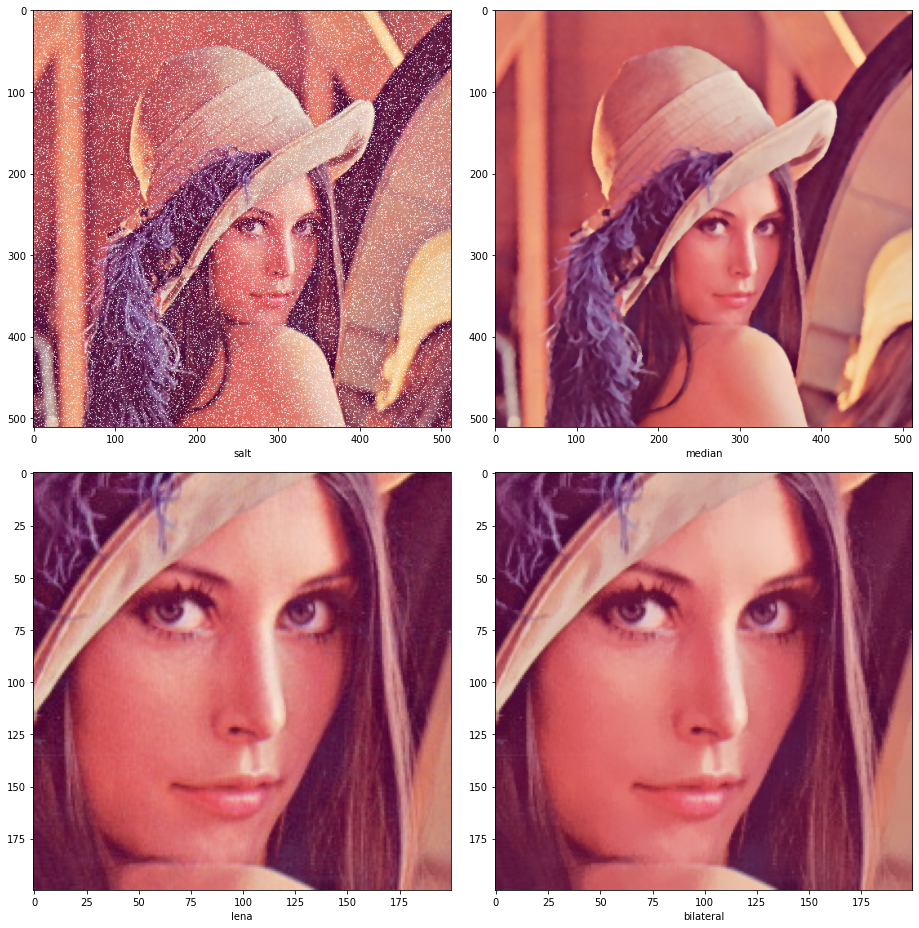

In [16]:
fig=plt.figure(figsize=(13,13))
plt.subplot(221)
plt.imshow(salt_img)
plt.xlabel("salt")

cv_median_img = cv2.medianBlur(salt_img,5)

plt.subplot(222)
plt.imshow(cv_median_img)
plt.xlabel("median")

plt.subplot(223)
plt.imshow(lena[200:400,200:400])
plt.xlabel("lena")

cv_bilateral_img = cv2.bilateralFilter(lena[200:400,200:400], 10,12.0,16.0)

plt.subplot(224)
plt.imshow(cv_bilateral_img)
plt.xlabel("bilateral")
fig.tight_layout()
plt.show()

### 기하연산
기하 연산은 영상을 회전시키거나 특정 영역을 크게 하는 등의 작업이 필요한 경우에 멀리 떨어져 있는 화소의 값들을 이용하는 연산이다.  
동차 좌표와 동차 행렬을 이용하면 좀 더 쉽게 연산이 가능하다.  
엄연히 말하면 z축이 아니지만 z가 1이고 y와 x는 유지하는 벡터로 표현한다고 생각하면 편하다.  
아래 그림 여러 기하연산들의 종류이다.  
![](./data/operation_geometric_matrix.jpg)

다음 그림은 전방 변환과 후방 변환에 대한 그림이다.  
![](./data/operation_forward_backward.jpg)
전방 변환은 현재 이미지를 타겟 이미지로 뿌린다고 생각하면 된다. 이때 빈 부분이 생기기 때문에 홀(hole)이 생긴다.
후방 변환은 생성될 이미지의 인덱스에서 현재 이미지 중 해당하는 인덱스를 가져온다고 생각하면 된다.  
전방 변환시 홀이 생기거나 후방 변환시 누락되는 이미지 때문에 시각적으로 불만족스러운 현상이 생긴다. 이러한 현상을 에일리어싱(aliasing)이라고 부른다.  
또한, 이러한 현상을 해소하려는 노력을 안티 에일리어싱(anti-aliasing)이라고 한다.

위의 두 방식에서 실수 좌표를 단순히 반올림하여 정수로 바꾸는데, 목표 영상의 여러 점이 원래 영상의 같은 점을 참조할 수 있으므로 에일리어싱 현상이 남는다. 이러한 문제를 해결하는 효과적인 안티 에일리어싱 기법은 보간(interpolation)이다.  
가장 간단한 방식은 반올림하여 정수로 바꾸는 방식은 최근접 이웃(nearest neighbor)방식이라 부른다.  
보간법은 정수의 인접 이웃들의 원래 이미지 값들에 거리에 반비례하는 가중치를 주고 이를 합하는 방식이다. 2차원으로 확장하면 다음과 같은 식이 된다.
$$
f(y,x')=(1-\alpha)f(y,x)+\alpha f(y,x+1) \\
f(y+1,x') = (1-\alpha)f(y+1,x)+\alpha f(y+1,x+1) \\
f(y',x') = (1-\beta)f(y,x')+\beta f(y+1,x')
$$
1차원 상에서만 보간을 수행할 때 선형 보간(linear interpolation)이라 한다.  
지금의 경우 y축과 x축 2방향에 대해서 선형 보간이 이루어지기 때문에 양방향 선형보간(bilinear interpolation)방법이라고 한다.

이번에도 역시나 레나로 실험한다.  
레나에서 roi를 지정하고 최근접 이웃과 양방향 선형보간을 이용해서 회전변환을 수행할 것이다.
쉽게 구현하기 위해 회전변환의 역행렬을 이용해서 후방 변환을 한다.  
참고로 각 인덱스별로 접근하는 방식으로 짜서 시간이 오래걸린다.  
gather 함수를 쓰면 좀 더 빠르게 할 수 있다.

In [17]:
def rotation(img,angle,method):
    angle = angle /180*np.pi
    cos =np.cos(angle)
    sin = np.sin(angle)
    out = np.zeros_like(img)
    if(method=='bilinear'):
        for y in range(len(img)):
            for x in range(len(img[0])):
                x_1 = x-2*cos - y*sin
                y_1 = x*sin+y*cos
                if x_1<0 or y_1<0 :
                    continue
                if abs(int(x_1+1)-np.clip(int(x_1+1),0,img.shape[0]-1)) >0 or abs(int(y_1+1)-np.clip(int(y_1+1),0,img.shape[1]-1))>1:
                    continue


                alpha = x_1 - int(x_1)
                beta = y_1 - int(y_1)
                xx = int(x_1)
                yy = int(y_1)

                if xx == img.shape[1]-1 and yy ==img.shape[0]-1:
                    out[y,x]=img[yy,xx]
                elif xx == img.shape[1]-1:
                    out[y,x]=img[yy,xx]*(1-beta)+img[yy+1,xx]*beta
                elif yy == img.shape[0]-1:
                    out[y,x]=img[yy,xx]*(1-alpha) + img[yy,xx+1]*alpha
                else:
                    pixel1 = img[yy,xx]*(1-alpha) + img[yy,xx+1]*alpha
                    pixel2 = img[yy+1,xx]*(1-alpha) + img[yy+1,xx+1]*alpha
                    out[y,x] = pixel1*(1-beta)+pixel2*beta
    elif method == 'nearest':
        for y in range(len(img)):
            for x in range(len(img)):
                x_1 = x * cos - y * sin
                y_1 = x * sin + y * cos
                if x_1 < 0 or y_1 < 0:
                    continue
                if abs(int(x_1 + 1) - np.clip(int(x_1 + 1), 0, img.shape[0] - 1)) > 0 or abs(
                        int(y_1 + 1) - np.clip(int(y_1 + 1), 0, img.shape[1] - 1)) > 1:
                    continue
                out[y,x] = img[np.clip(int(y_1+0.5),0,img.shape[1]-1),np.clip(int(x_1 + 0.5), 0, img.shape[0] - 1)]
    return out

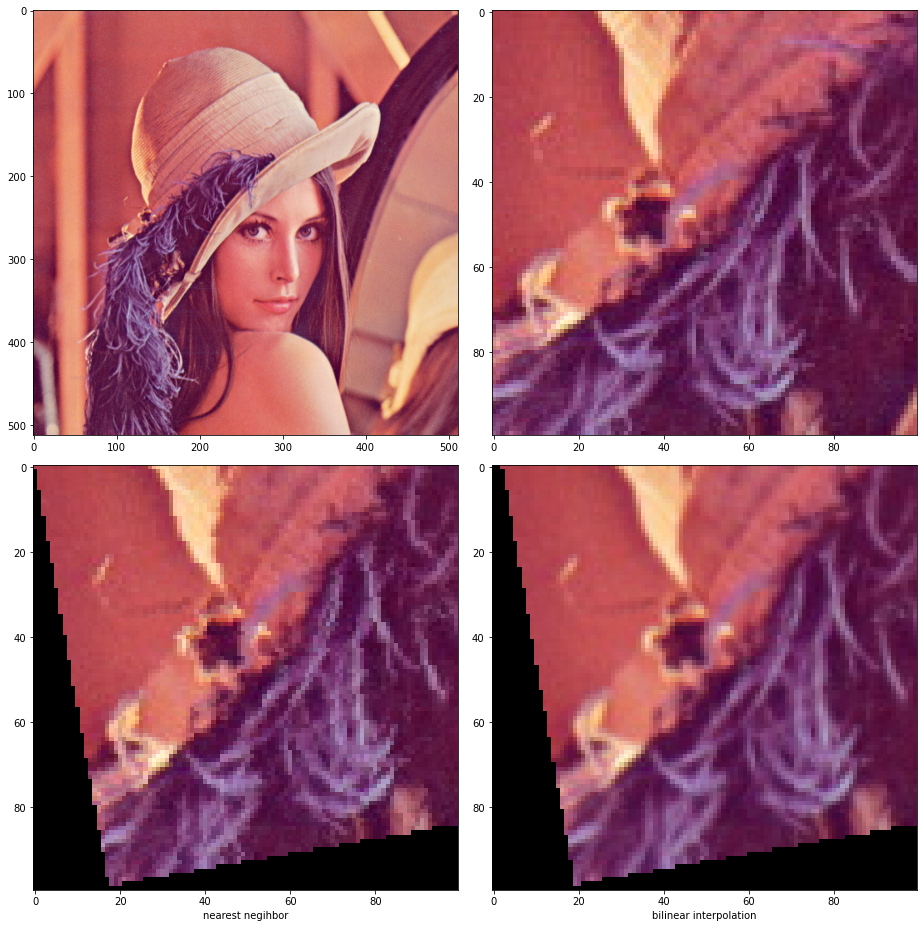

In [21]:
fig = plt.figure(figsize=(13,13))
plt.subplot(221)
plt.imshow(lena)

roi_resize=lena[200:300,100:200]
plt.subplot(222)
plt.imshow(roi_resize)


plt.subplot(223)
plt.imshow(rotation(roi_resize,10,'nearest'))
plt.xlabel("nearest negihbor")

plt.subplot(224)
plt.imshow(rotation(roi_resize,10,'bilinear'))
plt.xlabel('bilinear interpolation')
fig.tight_layout()
plt.show()

결과에서 최근접 이웃보다 양방향 선형보간 방식의 픽셀이 좀더 자연스러운 것을 볼 수 있다.